# Part 1: Basic Option Valuation
Carry out convergence studies by increasing the number of trials.  <br>
How do your results compare with the results obtained in assignment 1?  <br>
Perform numerical tests for varying values for the strike and the volatility parameter.  <br>
What is the standard error of your estimate and what does this tell you about the accuracy?

#TO DO
###Romy:
- Toch maar afspreken met die ene vriendin
- Vraag TA of vergelijking binomial tree ook nodig is.

###Jasper:
- Convergentie lijngrafiekmaken + Vraag TA Standard Error


###Steven:
- Kam je haar.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import random

from scipy.stats import norm
from numba import jit
from scipy import stats

In [8]:
# THIS IS NOW A PUT OPTION!

@jit (nopython = True)
def one_step_stock(stock_price, interest_rate, volatility, maturity):
    return stock_price * math.exp((interest_rate - 0.5 * volatility ** 2) * maturity + volatility * math.sqrt(maturity) * np.random.normal())

@jit (nopython = True)
def monte_carlo_option(trials, strike_price, stock_price, interest_rate, volatility, maturity):
    # trials are #iterations of monte carlo
    monte_results = []
    for i in range(trials):
        current_monte = one_step_stock(stock_price, interest_rate, volatility, maturity)
        if current_monte - strike_price < 0:
            monte_results.append((strike_price - current_monte)/ (1 + interest_rate))
        else:
            monte_results.append(0)
        
    return monte_results 
    

In [16]:
# @jit (nopython = True)
def experiment():
    ''' The Monte Carlo method.'''
    T = 1
    K = 99
    r = 0.06
    S0 = 100
    sigma = 0.2

    trials = 100000
    time0 = time.time()

    monte_total = []
    iters = 10000
    for i in range(iters):
        monte_results = monte_carlo_option(trials, K, S0, r, sigma, T)
        # print(time.time() - time0)

        # Mean and std
        monte_mean = np.mean(monte_results)
        monte_total.append(monte_mean)
    # monte_std = np.std(monte_results)
    return monte_total

In [17]:
results = experiment()

In [18]:
np.mean(results)

4.787420302450767

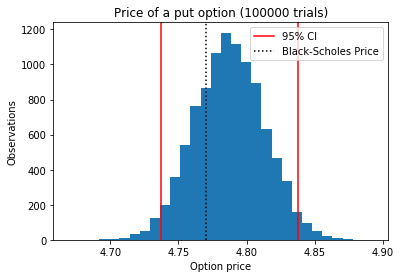

In [19]:
#Payoff kan nooit negatief zijn 
CI95 = stats.norm.interval(0.95, loc = np.mean(results), scale = np.std(results)) 
plt.axvline(CI95[0], color = 'r', label = '95% CI')
plt.axvline(4.77, color = 'black', linestyle = ':', label = 'Black-Scholes Price')
plt.axvline(CI95[1], color = 'r')

plt.legend()
plt.hist(results, bins = 30)
plt.ylabel('Observations')
plt.xlabel('Option price')
plt.title('Price of a put option (100000 trials)')
plt.savefig("100000trialsQ21Put.png")
plt.show()

In [ ]:
# '''  Varying the strike and the volatility. '''

# strike_list = [x for x in range(1,201)] #np.linspace(1,200)
# # print(strike_list)

# profit_list = []
# for K in strike_list:
#     profit = monte_carlo_option(trials, K, S0, r, sigma, T)
#     profit_list.append(profit)
     
# plt.plot(strike_list, profit)
# plt.title('Varying strike')
# plt.xlabel('Strike price')
# plt.ylabel('Profit or Loss')
# plt.legend()
# plt.show()

# Part 2: Estimation of Sensitivities in MC

## 1) Bump-and-revalue method.

In [20]:
@jit (nopython = True)
def one_step_stock(stock_price, interest_rate, volatility, maturity, Z):
    np.random.seed(5)
    return stock_price * math.exp((interest_rate - 0.5 * volatility ** 2) * maturity + volatility * math.sqrt(maturity) * Z)

@jit (nopython = True)
def monte_carlo_option(trials, strike_price, stock_price, interest_rate, volatility, maturity, randomness):
    # trials are #iterations of monte carlo
    monte_results = []
    for i in range(trials):
        current_monte = one_step_stock(stock_price, interest_rate, volatility, maturity, randomness[i])
        if current_monte - strike_price < 0:
            monte_results.append((strike_price - current_monte)/ (1 + interest_rate))
        else:
            monte_results.append(0)
        
    return monte_results 
    

In [21]:
def experiment(epsilon, randommess, trials = 1000):
    ''' The Monte Carlo method.'''
    T = 1
    K = 99
    r = 0.06
    S0 = 100 + epsilon
    sigma = 0.2

#     time0 = time.time()

    monte_total = []
    iters = 1
    for i in range(iters):
        monte_results = monte_carlo_option(trials, K, S0, r, sigma, T, randommess)
        # print(time.time() - time0)

        # Mean 
        monte_mean = np.mean(monte_results)
        monte_total.append(monte_mean)

    return monte_total

In [22]:
def euler(epsilon, trials, randommess = np.random.normal(size=1000), sameseed = True):    
    bumped = np.mean(experiment(epsilon, randommess, trials))
    if not sameseed:
        randommess = np.random.normal(size=1000)
    unbumped = np.mean(experiment(0, randommess, trials))
    
    delta = (bumped - unbumped) / epsilon
    return delta

In [23]:
""" Compute deltas for different seeds
    with epsilon 0.01, 0.02, 0.5. """

# Size 10^4
randommess = np.random.normal(size=int(1e4))
dif_delta4_1 = euler(1e-2, trials = 1e4, randommess = randommess, sameseed=False)
dif_delta4_2 = euler(2e-2, trials = 1e4, randommess = randommess, sameseed=False)
# dif_delta4_5 = euler(5e-1, trials = 1e4, randommess = randommess, sameseed=False)

# # Size 10^5
# randommess = np.random.normal(size=int(1e5))
# dif_delta5_1 = euler(1e-2, trials = 1e5, randommess = randommess, sameseed=False)
# dif_delta5_2 = euler(2e-2, trials = 1e5, randommess = randommess, sameseed=False)
# dif_delta5_5 = euler(5e-1, trials = 1e5, randommess = randommess, sameseed=False)

# # Size 10^6
# randommess = np.random.normal(size=int(1e6))
# dif_delta6_1 = euler(1e-2, trials = 1e6, randommess = randommess, sameseed=False)
# dif_delta6_2 = euler(2e-2, trials = 1e6, randommess = randommess, sameseed=False)
# dif_delta6_5 = euler(5e-1, trials = 1e6, randommess = randommess, sameseed=False)

# # Size 10^7
# randommess = np.random.normal(size=int(1e7))
# dif_delta7_1 = euler(1e-2, trials = 1e7, randommess = randommess, sameseed=False)
# dif_delta7_2 = euler(2e-2, trials = 1e7, randommess = randommess, sameseed=False)
# dif_delta7_5 = euler(5e-1, trials = 1e7, randommess = randommess, sameseed=False)


In [24]:
# """ Compute deltas for same seed 
#     with epsilon 0.01, 0.02, 0.5. """

# # Size 10^4
# randommess = np.random.normal(size=1e4)
# same_delta4_1 = euler(1e-2, trials = 1e4, randommess = randommess, sameseed=True)
# same_delta4_2 = euler(2e-2, trials = 1e4, randommess = randommess, sameseed=True)
# same_delta4_5 = euler(5e-1, trials = 1e4, randommess = randommess, sameseed=True)

# # Size 10^5
# randommess = np.random.normal(size=1e5)
# same_delta5_1 = euler(1e-2, trials = 1e5, randommess = randommess, sameseed=True)
# same_delta5_2 = euler(2e-2, trials = 1e5, randommess = randommess, sameseed=True)
# same_delta5_5 = euler(5e-1, trials = 1e5, randommess = randommess, sameseed=True)

# # Size 10^6
# randommess = np.random.normal(size=1e6)
# same_delta6_1 = euler(1e-2, trials = 1e6, randommess = randommess, sameseed=True)
# same_delta6_2 = euler(2e-2, trials = 1e6, randommess = randommess, sameseed=True)
# same_delta6_5 = euler(5e-1, trials = 1e6, randommess = randommess, sameseed=True)

# # Size 10^7
# randommess = np.random.normal(size=1e7)
# same_delta7_1 = euler(1e-2, trials = 1e7, randommess = randommess, sameseed=True)
# same_delta7_2 = euler(2e-2, trials = 1e7, randommess = randommess, sameseed=True)
# same_delta7_5 = euler(5e-1, trials = 1e7, randommess = randommess, sameseed=True)


In [25]:
""" The analytical value """
def black_scholes(stock_price = 100, strike_price = 99, interest_rate = 0.06, volatility = 0.20, T = 1):
    d1 = (math.log(stock_price / strike_price) + (interest_rate + (volatility ** 2) / 2) * T) / (volatility * math.sqrt(T))
    #d2 = d1 - volatility* math.sqrt(T)
    d2 = (math.log(stock_price / strike_price) + (interest_rate - (volatility ** 2) / 2) * T) / (volatility * math.sqrt(T))
   
    call = stock_price * norm.cdf(d1) - strike_price * math.exp(- interest_rate * T) * norm.cdf(d2)
    put = strike_price * math.exp(-interest_rate * T ) * norm.cdf(-d2) - stock_price * norm.cdf(-d1)

    return call, put

In [26]:
""" Relative error in percentage. """
def relative_error(true_value, approx_value):
    return ((true_value - approx_value) / true_value) * 100

In [39]:
""" Relative error is shown with analytical value as reference. """

#The analytical value
analytical_call, analytical_put = black_scholes()
print('The analytical price of the option:', analytical_put)

#######
# print(dif_delta4_1)
# print(dif_delta4_2)

number_of_trials = 100000
randommess = np.random.normal(size=number_of_trials)
# print(len(randommess))
check = euler(1e-8, trials = number_of_trials, randommess = randommess, sameseed=True)
print(check)

####
error = relative_error(analytical_put, check)
print(error)

The analytical price of the option: 4.778969051891707
100000
-0.3249825297757525
106.80026437181283


## 2)  Digital option

In [ ]:
import scipy

In [ ]:
def experiment2(epsilon, trials = 1000):
    ''' The Monte Carlo method.'''
    T = 1
    K = 100
    r = 0
    S0 = 100 + epsilon
    sigma = 0.2

#     time0 = time.time()

    monte_total = []
    newglobel = []
    iters = 10000
    for i in range(iters):
        randommess = np.random.normal(size = trials)
        monte_results = digital_option(trials, K, S0, r, sigma, T, randommess)
        newglobel.append(monte_results[1])
        # print(time.time() - time0)

        # Mean 
        monte_mean = np.mean(monte_results[0])
        monte_total.append(monte_mean)
    plt.hist(newglobel, 20)
    print(scipy.stats.normaltest(newglobel))
    plt.show()
    a = 0
    b = 0
    print(np.mean(newglobel))
    for i in newglobel:
        if i > 100:
            a = a +1
        else:
            b = b + 1
    print('a', a)
    print('b', b)
    return monte_total

jit (nopython = True)
def digital_option(trials, strike_price, stock_price, interest_rate, volatility, maturity, randomness):
    # trials are #iterations of monte carlo
    globallist = []
    monte_results = []
    
    acounter = 0
    bcounter = 0
    
    for i in range(trials):
        current_monte = one_step_stock(stock_price, interest_rate, volatility, maturity, randomness[i])
        globallist.append(current_monte)
        if current_monte - strike_price > 0:
            monte_results.append(1)
            acounter = acounter + 1
        else:
            monte_results.append(0)
            bcounter = bcounter + 1
    print(acounter)
    print(bcounter)
    print()
    plt.hist(globallist)
    plt.show()
    return monte_results, np.mean(globallist)

jit (nopython = True)
def one_step_stock(stock_price, interest_rate, volatility, maturity, Z):
    return stock_price * math.exp((interest_rate - 0.5 * volatility ** 2) * maturity + volatility * math.sqrt(maturity) * Z)

In [ ]:
plt.hist(experiment2(0.0))

# Part 3: Variance Reduction